# Sentiment analysis on restaurant reviews with NLTK and TextBlob

<ins>Date Created/ Submitted: 25 Feb 19</ins>

For this capstone project, the aim is to predict the sentiment of a review using sentiment analysis. And, apply topic modelling using LDA or similar analysis to identify key topics/ area within each sentiment class (e.g. which topics/areas garner mostly negative reviews and which topic/areas garner mostly postive reviews).

This python implementation of this project is split into several python notebooks.
* Part 1: Web-scraping review data (The code for this is not uploaded to github)
* Part 2: Explore the data
* Part 3: Prepare the data (pre-processing)
* Part 4a: Modelling using word vector generated from CountVectorizer
* Part 4b: Modelling using word vector generated from TDIDFVectorizer
* Part 5: Summary Results with Topics Identified

### Part 1. Web-scraping review data ###
While the code for web-scraping of reviews is not uploaded into github, the background of this analysis is that I was preparing for a two month trip to Sydney. And had used this opportunity to identify popular restaurants of various cuisines, its reviews etc in tandem. Hence the data involves restaurant reviews of Sydney and its surrounds. Out of more than 17k restaurants, only the user reviews of restaurants with at least 100 reviews were scraped for further analysis.

### Part 2. Explore the data ###

Note: Output of some cells have been cleared to desensitize the source of the web-scraping.

### Setting Up the Environment

In [1]:
# Load necessary libraries for data exploration
import time
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

# Set seed for replicability.
seedno = 18704
np.random.seed(seedno)

# Set nb run start time to compute total runtime
nbstarttime= time.time()

# Define float display to 4 decimal places
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
def plot_bars(attribute,setpalette='Spectral',setrotation=0,showlabels=True,sortvalue='ascending',sortcount=None):
    sns.set(style="whitegrid")
# Store frequency counts of each label where unique is the label and counts is its frequency
    unique, counts = np.unique(attribute.astype(str), return_counts=True)
    unique_counts = pd.DataFrame({'Value': unique, 'Count': counts})
    if sortvalue == 'descending':
        unique_counts = unique_counts.sort_values('Value', ascending=False)
    if sortvalue == 'ascending':
        unique_counts = unique_counts.sort_values('Value', ascending=True)
    if sortcount == 'descending':
        unique_counts = unique_counts.sort_values('Count', ascending=False)
    if sortcount == 'ascending':
        unique_counts = unique_counts.sort_values('Count', ascending=True)

# plot frequency counts
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.barplot(x="Value", y="Count", data=unique_counts,palette=setpalette)
    if showlabels==True:
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height),
            ha="center") 
    plt.setp(ax.get_xticklabels(), rotation=setrotation)
    plt.show()

### Restaurant List Dataset

In [3]:
restaurant_list = pd.read_csv('restaurant_list.csv')
restaurant_list = restaurant_list.drop(['Unnamed: 0'], axis=1)

In [4]:
display(restaurant_list.shape)
display(restaurant_list['restaurant_reviewcount'\
                       ].sum().astype(int))
display(restaurant_list.columns.tolist())

(17066, 9)

725935

['restaurant_url',
 'restaurant_id',
 'restaurant_name',
 'restaurant_rating',
 'restaurant_reviewcount',
 'restaurant_poptext',
 'restaurant_subpoptext',
 'restaurant_pricerange',
 'restaurant_cuisines']

In [ ]:
display(restaurant_list.sort_values('restaurant_reviewcount',ascending=False).head(3))
display(restaurant_list.sort_values('restaurant_reviewcount',ascending=False).tail(3))

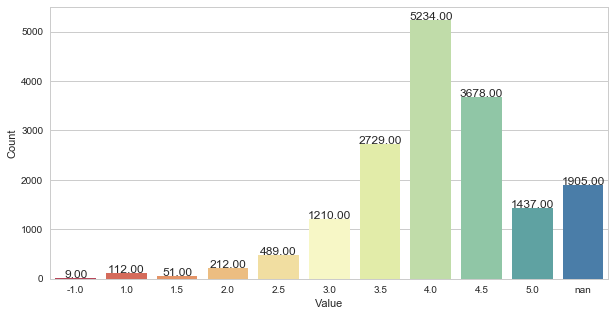

In [6]:
plot_bars(restaurant_list['restaurant_rating'])

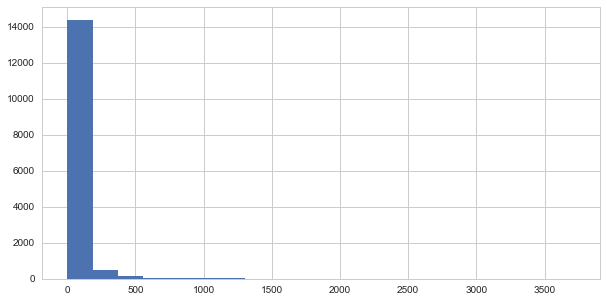

In [7]:
restaurant_list['restaurant_reviewcount'].hist(bins=20,figsize=(10,5))

In [8]:
display(len(restaurant_list[restaurant_list['restaurant_reviewcount']>=100]))

1704

In [9]:
restaurant_list[restaurant_list['restaurant_reviewcount']>=100]['restaurant_reviewcount'].sum()

466093.0

Based on the number of reviews by restaurant, we noted that majority of 8317 restaurant in Sydney and its surrounds only received less than 100 reviews. For our project, we will only focus on th 1155 restaurants which received 100 reviews or more. We hence further extract restaurant information and reviews for these 1155 restaurants.

### Restaurant Info Dataset

In [10]:
restaurant_info = pd.read_csv('restaurant_info.csv')
restaurant_info = restaurant_info.drop(['Unnamed: 0'], axis=1)

In [ ]:
display(restaurant_info.shape)
display(restaurant_info.tail(3))

In [12]:
restaurant_info.isnull().sum()

restaurant_url                 0
restaurant_id                  0
restaurant_name                0
restaurant_rating              0
restaurant_reviewcount         0
restaurant_ranking             3
restaurant_pricerange          2
restaurant_cat                 4
restaurant_foodrating          2
restaurant_valuerating         1
restaurant_servicerating       2
restaurant_atmrating         281
restaurant_cuisines           17
restaurant_diets             138
restaurant_meals              87
restaurant_features            1
restaurant_address             5
restaurant_extaddress       1082
restaurant_locality            0
restaurant_country             0
restaurant_lat                 0
restaurant_long                0
dtype: int64

In [13]:
restaurant_info.shape[0] - restaurant_info.dropna().shape[0]

1256

In [14]:
cuisines=[]
for cuisine in restaurant_info['restaurant_cuisines']:
    cuisine1=str(cuisine).replace('More','')
    cuisine2=' '.join(str(cuisine1).split())
    cuisine3=re.sub('\s+', ' ', cuisine2).strip()
    cuisines.append(cuisine3)

In [15]:
print(len(cuisines))

1704


In [16]:
restaurant_info['cuisines_clean']=cuisines

In [17]:
# cuisine_dummies=restaurant_info['cuisines_clean'].str.get_dummies(sep=',')
# cuisine_dummies=cuisine_dummies.add_prefix('cuisine_')
# restaurant_info = pd.concat([restaurant_info, cuisine_dummies],axis=1)

In [18]:
diets=[]
for diet in restaurant_info['restaurant_diets']:
    diet1=str(diet).replace('More','')
    diet2=' '.join(str(diet1).split())
    diet3=re.sub('\s+', ' ', diet2).strip()
    diets.append(diet3)

In [19]:
print(len(diets))

1704


In [20]:
restaurant_info['diets_clean']=diets

In [21]:
# diet_dummies=restaurant_info['diets_clean'].str.get_dummies(sep=',')
# diet_dummies=cuisine_dummies.add_prefix('diet_')
# restaurant_info = pd.concat([restaurant_info, diet_dummies],axis=1)

In [22]:
features=[]
for feature in restaurant_info['restaurant_features']:
    feature1=str(feature).replace('More','')
    feature2=' '.join(str(feature1).split())
    feature3=re.sub('\s+', ' ', feature2).strip()
    features.append(feature3)

In [23]:
print(len(features))

1704


In [24]:
restaurant_info['features_clean']=features

In [25]:
# feature_dummies=restaurant_info['features_clean'].str.get_dummies(sep=',')
# feature_dummies=feature_dummies.add_prefix('feature_')
# restaurant_info = pd.concat([restaurant_info, feature_dummies],axis=1)

In [ ]:
restaurant_info.head(5)

In [27]:
#Write the dataset to csv
restaurant_info.to_csv('restaurant_info_clean.csv')

In [29]:
# we use the count vectorizer function to view distribution of cuisines
from sklearn.feature_extraction.text import CountVectorizer
rcuisine_vec = CountVectorizer()
rcuisine_vec.fit(restaurant_info['cuisines_clean'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [30]:
rcuisine_vec_matrix = rcuisine_vec.transform(restaurant_info['cuisines_clean'])

In [31]:
sum_words=rcuisine_vec_matrix.sum(axis=0)

In [32]:
words_freq = [(word, sum_words[0, idx]) for word, idx in rcuisine_vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [36]:
words_freq[0:10]

[('australian', 893),
 ('bar', 322),
 ('cafe', 316),
 ('asian', 282),
 ('italian', 261),
 ('mediterranean', 177),
 ('pizza', 176),
 ('seafood', 166),
 ('pub', 156),
 ('european', 123)]

In [33]:
d={}
for w, count in words_freq:
    d[w] = count

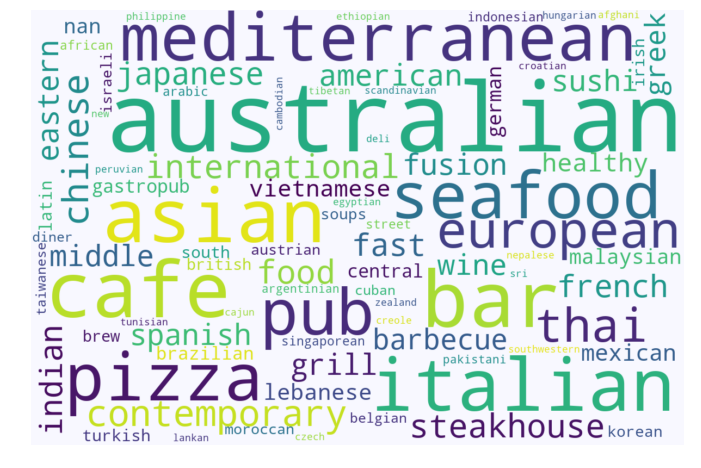

In [44]:
from wordcloud import WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.misc import imread
from palettable.colorbrewer.diverging import Spectral_9
from matplotlib.colors import makeMappingArray

#Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
#See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py
wordcloud = WordCloud(width=1200,height=800, background_color="whitesmoke", max_words=500,relative_scaling=0.3,normalize_plurals=False).generate_from_frequencies(d)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.show()